In [1]:
# -- PART 0: Import Statements
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings 

from scipy.stats import chi2_contingency 
from sklearn.model_selection import train_test_split, GridSearchCV 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# -- PART 1: Load the Data

cols = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']
df = pd.read_csv('processed.cleveland.data', names = cols)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0


DATA NOTES

INTEGER VARIABLES
- **age:** in years 
- **trestbps:** resting blood pressure (mm Hg)
- **chol:** serum cholesterol (mg/dl)
- **thalac:** maximum heart rate achieved
- **old peak:** ST depressed induced by exercise relative to rest
- **ca:** number of major vessels 

CATEGORICAL VARIABLES

Nominal (ranking doesn't matter)
- **sex**: (0 = female, 1 = male)
- **fbs:** fasting blood sugar (0 = not fasting, 1 = fasting)
- **exang:** exercise-induced ST-depression relative to rest (0 = no chest pain, 1 = chest pain)
- **num**: Label! (0 = no heart disease present, 1-4 = heart disease present)

Ordinal (ranking matters) 
- **cp:** chest pain type (0 = typical agina (heart-related chest pain), 1 = atypical agina, 2 = non-anginal pain, 3 = asymptomatic)
- **restecg:** resting ecg (0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy)
- **slope:** slope of peak exercise ST segment (0 = upsloping, 1 = flat, 2 = downsloping) [TK - <- category 3??]
- **thal:** thalassemia (blood disorder indicator) (0 = normal, 1 = fixed defect, 2 = reversible defect) [TK - <- category 6/7??]

In [3]:
# -- PART 2: Data Preprocessing 

# ---- (a) Handle Missing Values 

# check for ? values in dataset
df.replace('?', np.nan, inplace=True)

# check for NaN values in the dataset
df.isna().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          4
thal        2
num         0
dtype: int64

In [4]:
# 4 missing for ca and 2 for thal, can impute with median, but choosing to simply drop due to sample size
df = df.dropna(subset = ['ca', 'thal'])

In [5]:
# ---- (b) create new column class (label) that converts num to a binary classification problem 
df['class'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,class
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0,0


In [6]:
# ---- (c) handle variable data types 

# check data types 
df.dtypes

age         float64
sex         float64
cp          float64
trestbps    float64
chol        float64
fbs         float64
restecg     float64
thalach     float64
exang       float64
oldpeak     float64
slope       float64
ca           object
thal         object
num           int64
class         int64
dtype: object

In [7]:
# cast data 

# integer variables
df['age'] = df['age'].astype('int')
df['trestbps'] = df['trestbps'].astype('int')
df['chol'] = pd.to_numeric(df['thal']).astype('int')
df['thalach'] = pd.to_numeric(df['thalach']).astype('int')
df['ca'] = pd.to_numeric(df['ca']).astype('int')

# categorical variables (nominal)
df['sex'] = df['sex'].astype('int')
df['fbs'] = df['fbs'].astype('int')
df['exang'] = df['exang'].astype('int')

# categorical variables (ordinal)
df['cp'] = df['cp'].astype('int')
df['restecg'] = df['restecg'].astype('int')
df['slope'] = df['slope'].astype('int')
df['thal'] = pd.to_numeric(df['thal']).astype('int')

df

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,class
0,63,1,1,145,6,1,2,150,0,2.3,3,0,6,0,0
1,67,1,4,160,3,0,2,108,1,1.5,2,3,3,2,1
2,67,1,4,120,7,0,2,129,1,2.6,2,2,7,1,1
3,37,1,3,130,3,0,0,187,0,3.5,3,0,3,0,0
4,41,0,2,130,3,0,2,172,0,1.4,1,0,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,4,140,7,0,0,123,1,0.2,2,0,7,1,1
298,45,1,1,110,7,0,0,132,0,1.2,2,0,7,1,1
299,68,1,4,144,7,1,0,141,0,3.4,2,2,7,2,1
300,57,1,4,130,7,0,0,115,1,1.2,2,1,7,3,1


In [8]:
# -- PART 3: Data Visualization 
quant_cols = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca']
bin_cat_cols = ['sex', 'fbs', 'exang']
multi_cat_cols = ['cp', 'restecg', 'slope', 'thal']

In [9]:
# compare quantitative vars with binary outcome 
for col in quant_cols: 
    print(f"\n--- {col.upper()} ---")
    print(df.groupby('class')[col].describe().round(2))


--- AGE ---
       count   mean   std   min    25%   50%   75%   max
class                                                   
0      160.0  52.64  9.55  29.0  44.75  52.0  59.0  76.0
1      137.0  56.76  7.90  35.0  53.00  58.0  62.0  77.0

--- TRESTBPS ---
       count    mean    std    min    25%    50%    75%    max
class                                                         
0      160.0  129.18  16.37   94.0  120.0  130.0  140.0  180.0
1      137.0  134.64  18.90  100.0  120.0  130.0  145.0  200.0

--- CHOL ---
       count  mean   std  min  25%  50%  75%  max
class                                            
0      160.0  3.79  1.56  3.0  3.0  3.0  3.0  7.0
1      137.0  5.83  1.75  3.0  3.0  7.0  7.0  7.0

--- THALACH ---
       count    mean    std   min    25%    50%    75%    max
class                                                        
0      160.0  158.58  19.04  96.0  149.0  161.0  172.0  202.0
1      137.0  139.11  22.71  71.0  125.0  142.0  157.0  195.0

--- OLDPE

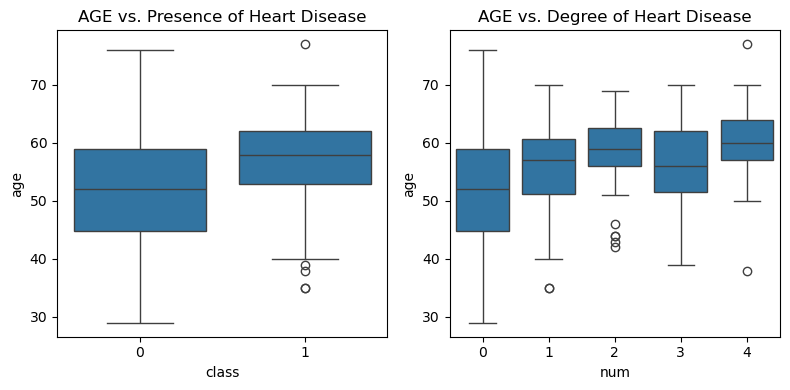

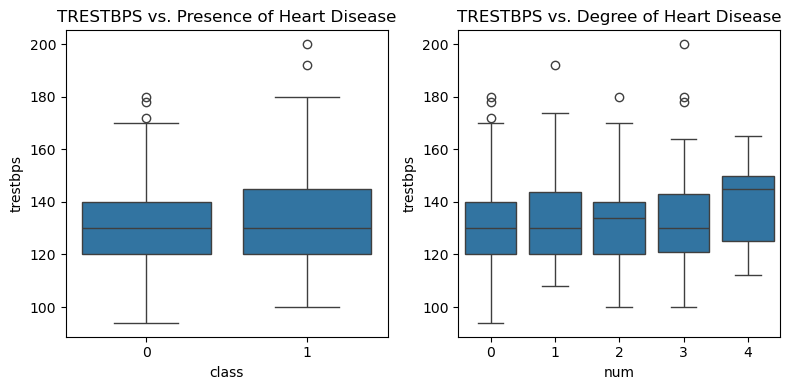

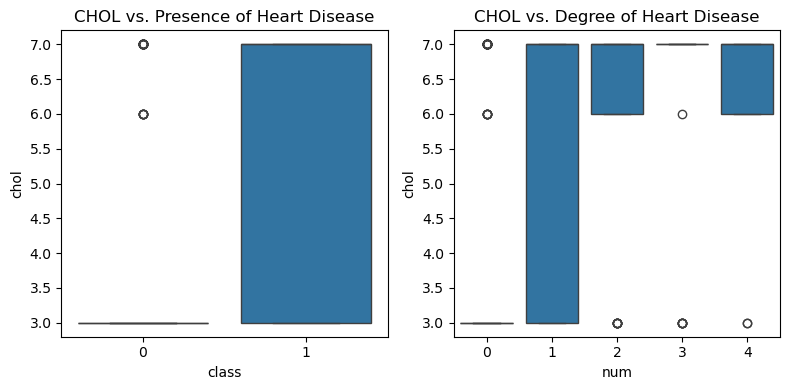

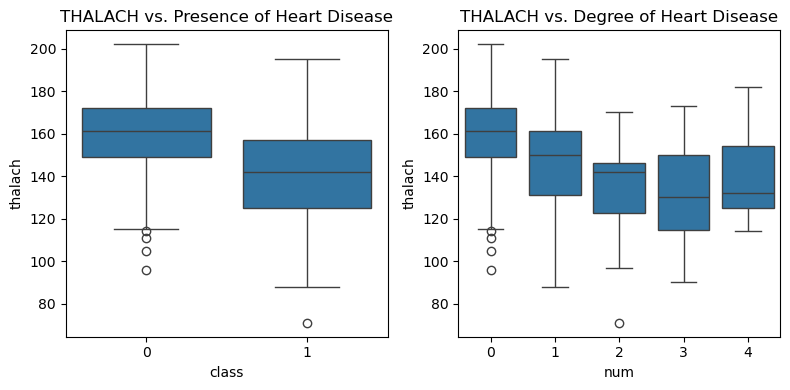

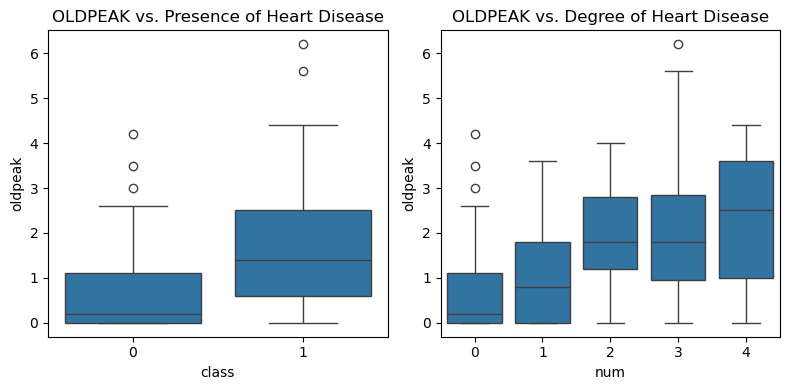

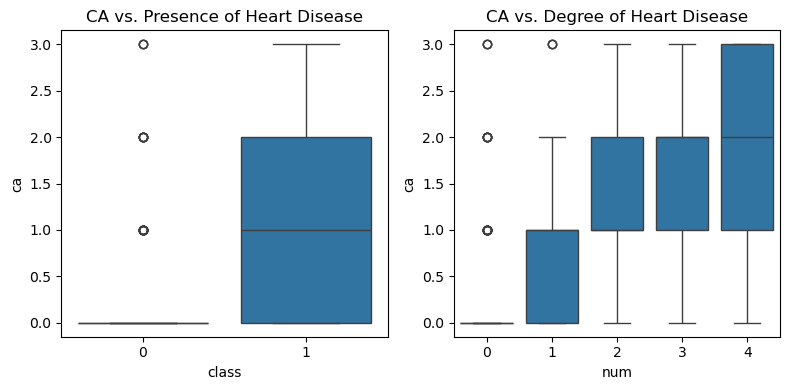

In [10]:
# visualize quantitative vars with outcome 
for col in quant_cols: 
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    sns.boxplot(df, x = 'class', y = col)
    plt.title(f'{col.upper()} vs. Presence of Heart Disease')

    plt.subplot(1,2,2)
    sns.boxplot(df, x = 'num', y = col)
    plt.title(f'{col.upper()} vs. Degree of Heart Disease')

    plt.tight_layout()
    plt.show()

# all quantitative variables have some amount of variation with age, thalach, oldpeak and ca having 
# the most impact 

In [11]:
# compare binary categorical vars with binary outcome 
for col in bin_cat_cols: 
    print(f"\n--- {col.upper()} ---")
    print(pd.crosstab(df[col], df['class'], normalize='columns').round(2))

# can see a moderate impact with sex, strong variation in exange and non-existent for fbs 


--- SEX ---
class     0     1
sex              
0      0.44  0.18
1      0.56  0.82

--- FBS ---
class     0     1
fbs              
0      0.86  0.85
1      0.14  0.15

--- EXANG ---
class     0     1
exang            
0      0.86  0.46
1      0.14  0.54


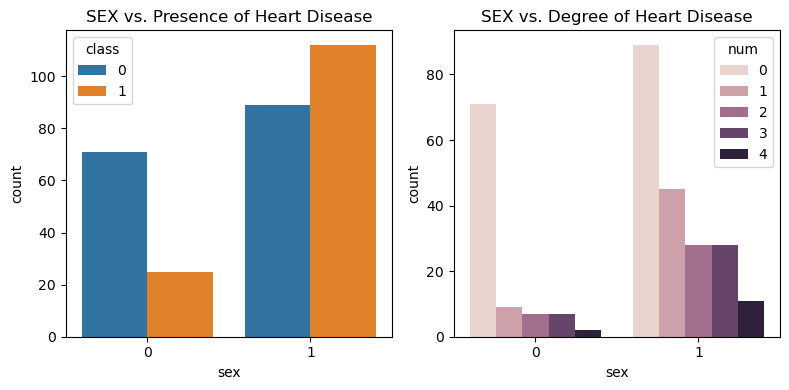

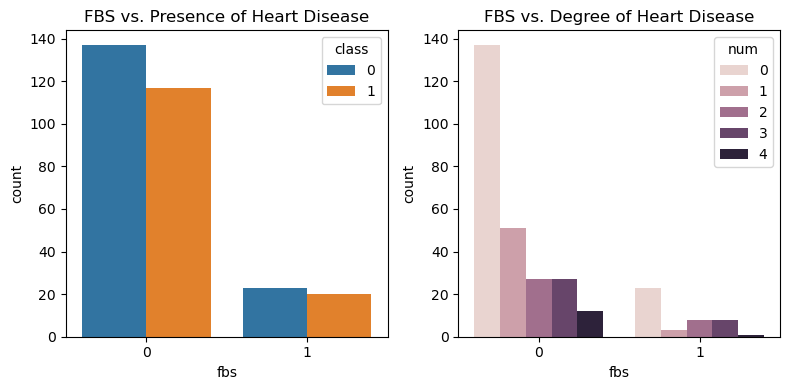

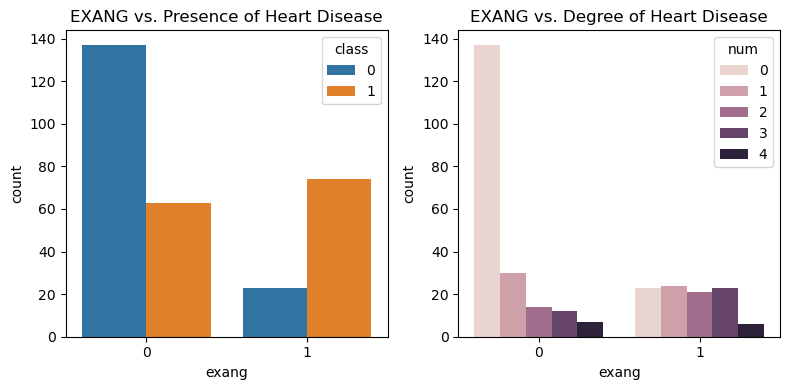

In [12]:
# visualize binary categorical vars with outcome 
for col in bin_cat_cols: 
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    sns.countplot(df, x = col, hue = 'class')
    plt.title(f'{col.upper()} vs. Presence of Heart Disease')

    plt.subplot(1,2,2)
    sns.countplot(df, x = col, hue = 'num')
    plt.title(f'{col.upper()} vs. Degree of Heart Disease')

    plt.tight_layout()
    plt.show()

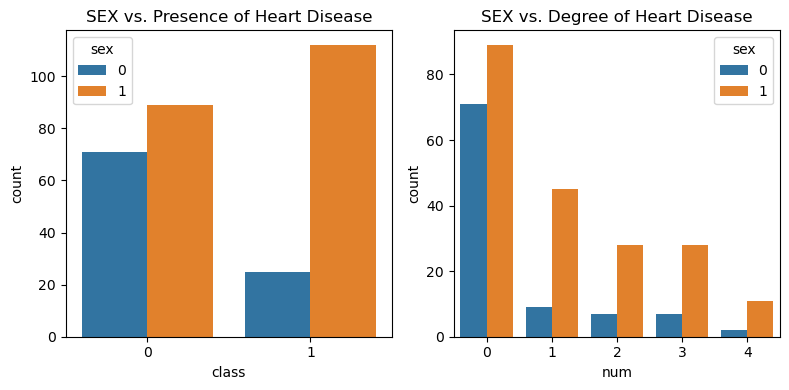

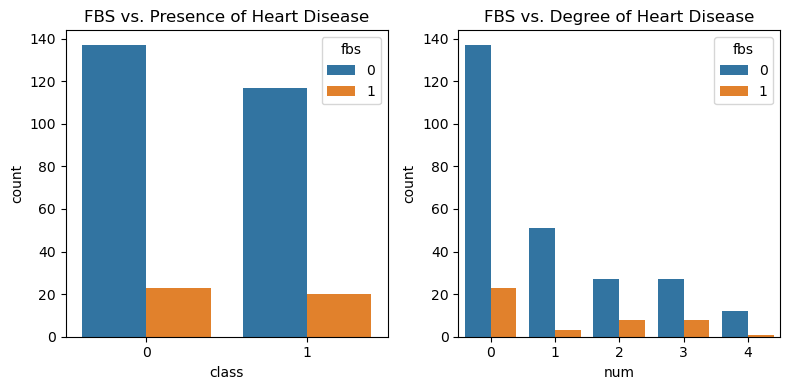

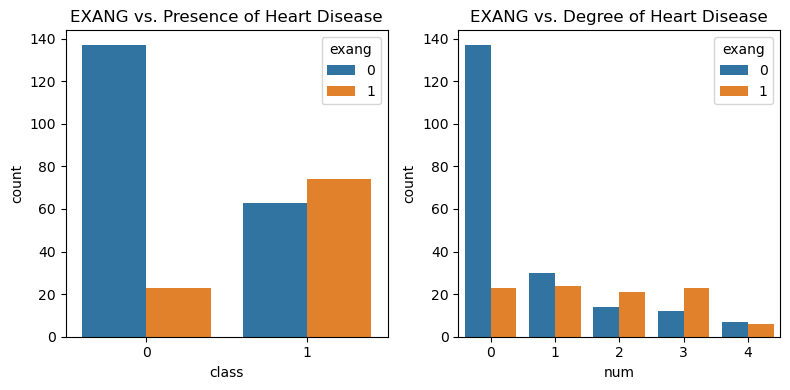

In [13]:
for col in bin_cat_cols: 
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    sns.countplot(df, x = 'class', hue = col)
    plt.title(f'{col.upper()} vs. Presence of Heart Disease')

    plt.subplot(1,2,2)
    sns.countplot(df, x = 'num', hue = col)
    plt.title(f'{col.upper()} vs. Degree of Heart Disease')

    plt.tight_layout()
    plt.show()

In [14]:
# compare binary categorical vars with binary outcome 
for col in multi_cat_cols: 
    print(f"\n--- {col.upper()} ---")
    print(pd.crosstab(df[col], df['class'], normalize='columns').round(2))

# can see a moderate impact with restecg and a strong impact from cp (4), restecg (2), 
# slope (2), thal (7)


--- CP ---
class     0     1
cp               
1      0.10  0.05
2      0.25  0.07
3      0.41  0.13
4      0.24  0.75

--- RESTECG ---
class       0     1
restecg            
0        0.57  0.40
1        0.01  0.02
2        0.42  0.58

--- SLOPE ---
class     0     1
slope            
1      0.64  0.26
2      0.30  0.65
3      0.06  0.09

--- THAL ---
class     0     1
thal             
3      0.79  0.27
6      0.04  0.09
7      0.17  0.64


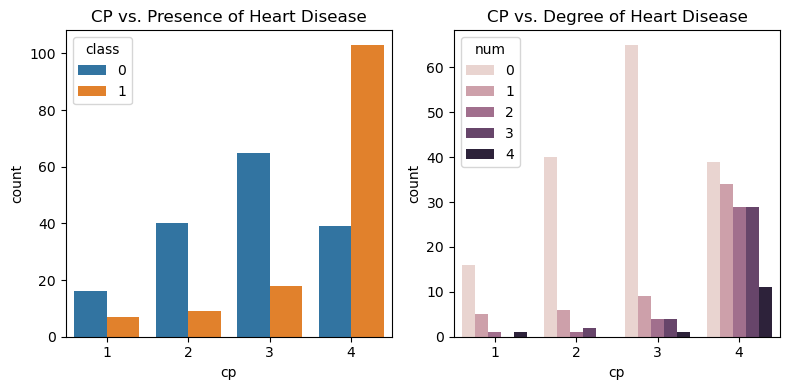

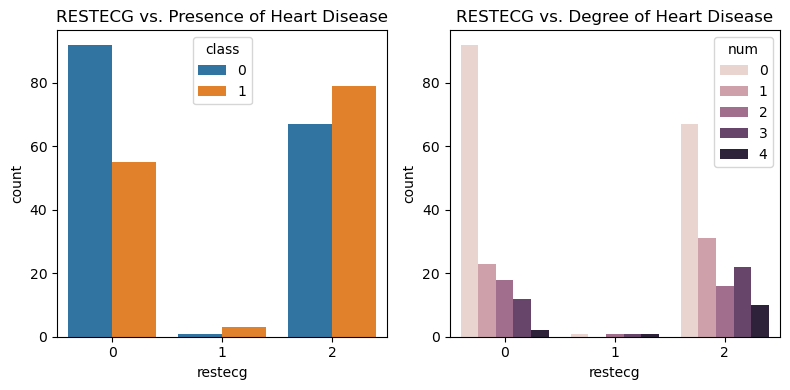

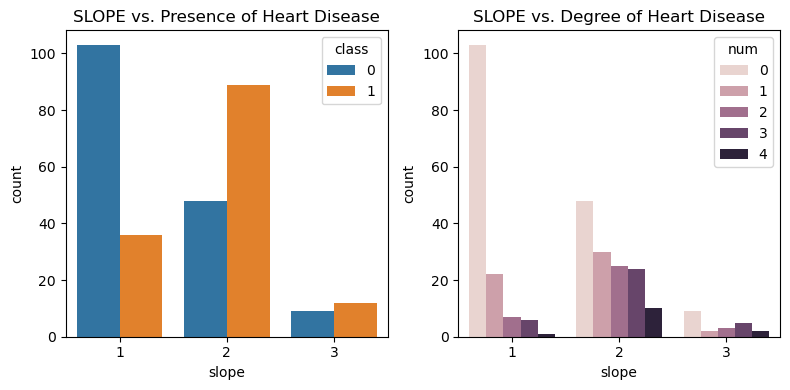

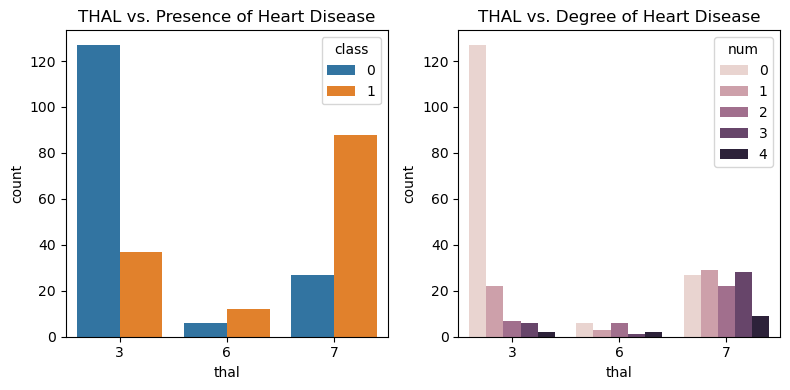

In [15]:
# visualize binary categorical vars with outcome 
for col in multi_cat_cols: 
    plt.figure(figsize=(8,4))

    plt.subplot(1,2,1)
    sns.countplot(df, x = col, hue = 'class')
    plt.title(f'{col.upper()} vs. Presence of Heart Disease')

    plt.subplot(1,2,2)
    sns.countplot(df, x = col, hue = 'num')
    plt.title(f'{col.upper()} vs. Degree of Heart Disease')

    plt.tight_layout()
    plt.show()

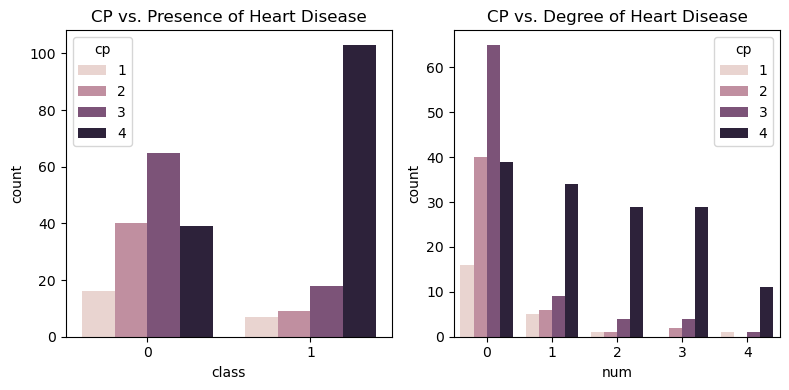

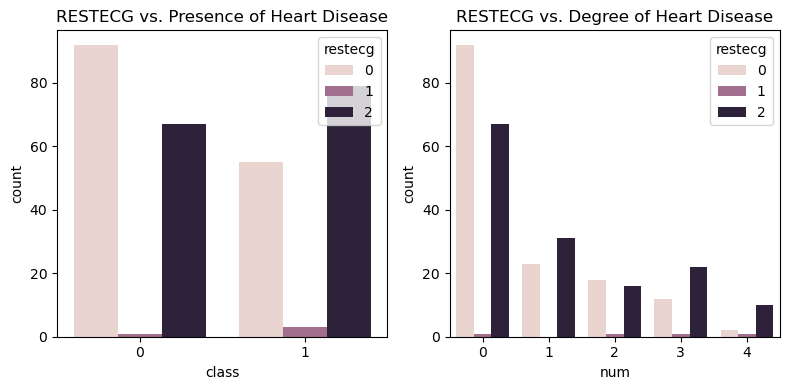

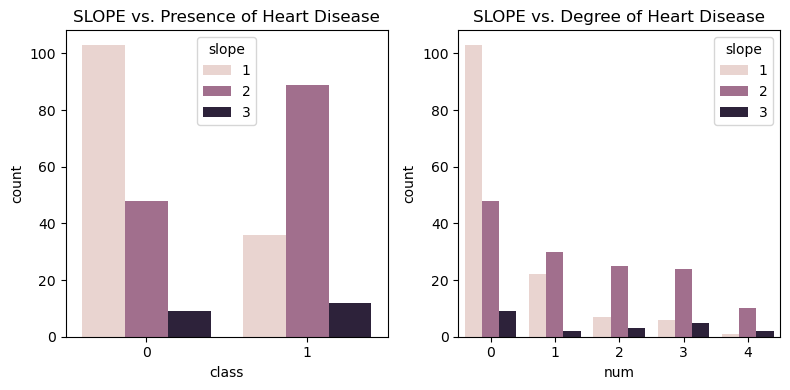

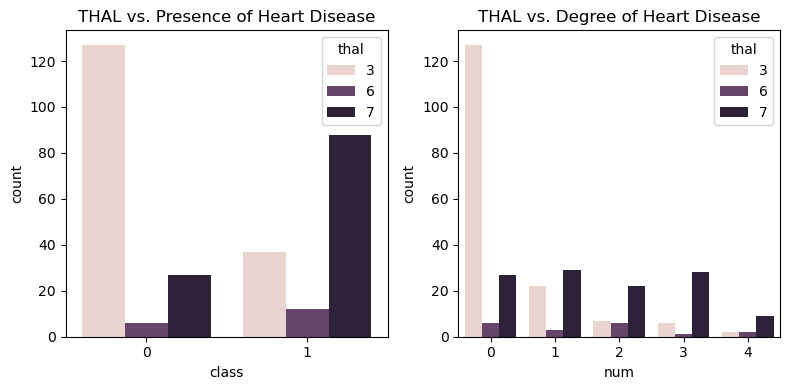

In [16]:
for col in multi_cat_cols: 
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    sns.countplot(df, x = 'class', hue = col)
    plt.title(f'{col.upper()} vs. Presence of Heart Disease')

    plt.subplot(1,2,2)
    sns.countplot(df, x = 'num', hue = col)
    plt.title(f'{col.upper()} vs. Degree of Heart Disease')

    plt.tight_layout()
    plt.show()

<Axes: >

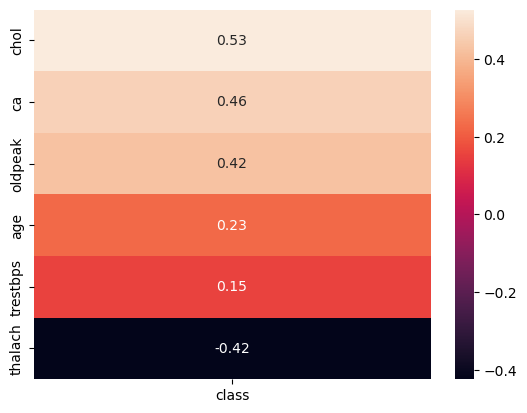

In [ ]:
# correlation map with outcome variables for quantitative variables
corr = df[quant_cols].corrwith(df['class']).sort_values(ascending=False)
corr_df = corr.to_frame(name='class')
sns.heatmap(corr_df, annot=True, fmt = '.2f')

# can see that all are fairly strong predictors with good correlation with class from chol, ca, oldpeak and thalach, and weaker predictors in age and trestbps

Text(0.5, 1.0, 'Correlation Matrix of Numeric Variables')

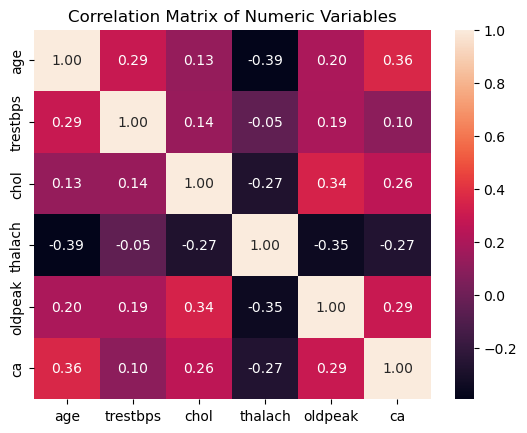

In [17]:
# do a correlation map for quantitative variables (redundancy check)
# results = not strong enugh to remove 
sns.heatmap(df[quant_cols].corr(), annot=True, fmt='.2f')
plt.title("Correlation Matrix of Numeric Variables")

In [18]:
# check for association across categorical columns using cramers

def compute_cramers_v(col_a, col_b): 
    conf_mat = pd.crosstab(col_a, col_b)
    chi2 = chi2_contingency(conf_mat)[0]
    n = conf_mat.sum().sum()
    r, k = conf_mat.shape
    phi2 = chi2/n

    v = np.sqrt(phi2 / min(r-1, k-1))

    return v



<Axes: >

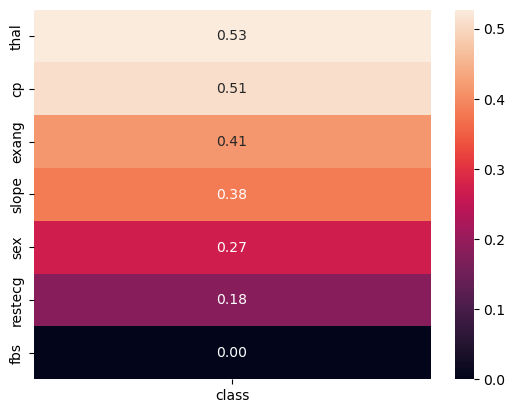

In [ ]:
# correlation map with outcome variables for categorical variables
cat_cols = bin_cat_cols + multi_cat_cols

cramers_vec = []
for i, col in enumerate(cat_cols): 
    cramers_vec.append(compute_cramers_v(df[col], df['class']))

cramers_df = pd.Series(cramers_vec, index=cat_cols).to_frame(name='class').sort_values(by = 'class', ascending=False)
sns.heatmap(cramers_df, annot=True, fmt = '.2f')

# can see that there is a strong correlation with class for thal, chp, a slightly weaker correlation for exang, slope, an weaker one for sex and restecg and a non-existnet one for fbs 
# (not enough to drop, just can conclude th'/Users/rohitanalluri/Desktop/Pillar III/Career/Portfolio/heart-disease-prediction'at there's no linear relationship with the variables)

In [ ]:
# get chi squared test results 
cramers_mat = pd.DataFrame(index=cat_cols, columns = cat_cols)

for col_a in cat_cols: 
    for col_b in cat_cols: 
        cramers_mat.loc[col_a, col_b] = compute_cramers_v(df[col_a], df[col_b])

cramers_mat = cramers_mat.astype(float)

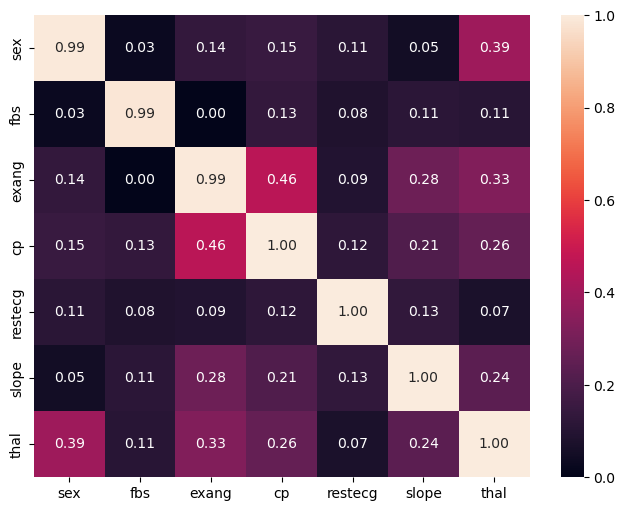

In [20]:
plt.figure(figsize=(8,6))
sns.heatmap(cramers_mat, annot=True, fmt='.2f')
plt.show()

# can see that there's moderate associations (max at 0.39 b/w sex and thal) but not
# enough to drop for redundancy

In [65]:
# -- PART 4: Model Training & Evaluation 

# ---- (a) Split Dataset into Training, Test and Validation (0.7/0.15/0.15)
X = df.drop(columns = ['num', 'class'])
y = df['class']

In [66]:
# ---- (b) Train Logistic Regression Model 

# ------ (i) manual hyperparameter tuning for C via validation set

# variant one for validation set 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.3, random_state = 20, stratify = y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, random_state = 20, stratify = y_temp)

best_acc = 0
best_C = 0

C_opt = [0.01, 0.1, 1, 10, 100]
for C in C_opt: 
    # fit model 
    model = LogisticRegression(max_iter = 1000)
    model.fit(X_train, y_train)
    
    # predict y-values on validation set and compare
    y_val_pred = model.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)

    if acc > best_acc: 
        best_acc = acc
        best_C = C

print('Best C: ', best_C, ' @ Accuracy of ', best_acc)


Best C:  0.01  @ Accuracy of  0.8666666666666667


In [67]:
# ------ (ii) Grid Search for best c, penalty and solver 

# variant two for no validation set (using k-folds instead)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 20, stratify = y)

param_grid_l1 = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

param_grid_l2 = {
    'C': [0.01, 0.1, 1, 10, 100], 
    'penalty': ['l2'],
    'solver': ['newton-cg', 'lbfgs']
}

param_grid = [
    {'C': param_grid_l1['C'], 'penalty': param_grid_l1['penalty'], 'solver': param_grid_l1['solver']}, 
    {'C': param_grid_l2['C'], 'penalty': param_grid_l2['penalty'], 'solver': param_grid_l2['solver']}
]

# suppress convergence warning
warnings.simplefilter('ignore', ConvergenceWarning)

log_grid = GridSearchCV(
    LogisticRegression(max_iter=1000, random_state=20), 
    param_grid, 
    cv=5, 
    scoring='accuracy'
)

log_grid.fit(X_train, y_train)

print("Best Parameters:", log_grid.best_params_, " @ Accuracy of ", log_grid.best_score_)

log_top_five = pd.DataFrame(log_grid.cv_results_).sort_values('mean_test_score', ascending = False).head(5)
log_top_five[['param_C', 'param_penalty', 'param_solver', 'mean_test_score']]

Best Parameters: {'C': 1, 'penalty': 'l2', 'solver': 'newton-cg'}  @ Accuracy of  0.8211382113821137


,param_C,param_penalty,param_solver,mean_test_score
24,1.0,l2,newton-cg,0.821138
25,1.0,l2,lbfgs,0.821138
14,10.0,l2,liblinear,0.816492
22,0.1,l2,newton-cg,0.806620
23,0.1,l2,lbfgs,0.806620


In [68]:
# ------ (ii) fit final model 
log_model = LogisticRegression(C = 1, penalty = 'l2', solver = 'newton-cg')
log_model.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'newton-cg'
,max_iter,100
,multi_class,'deprecated'


In [69]:
# ------ (iii) evaluate model 
y_test_pred = log_model.predict(X_test)

print("Accuracy Score: ", round(accuracy_score(y_test, y_test_pred), 2))
print("")
print("Classification Report: \n", classification_report(y_test, y_test_pred))

print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred))

Accuracy Score:  0.86

Classification Report: 
               precision    recall  f1-score   support

           0       0.87      0.85      0.86        48
           1       0.84      0.86      0.85        42

    accuracy                           0.86        90
   macro avg       0.85      0.86      0.86        90
weighted avg       0.86      0.86      0.86        90

Confusion Matrix: 
 [[41  7]
 [ 6 36]]


NOTE: class 0 = no heart disease present and class 1 = heart disease present 

From above, we can see that our model is performing well (accuracy of 0.86): 

- with a precision score (how many really were) of 0.87 for class 0 and 0.84 for class 1, we can see that when the model is predicting class 0/1 and it actually is class 0/1 respectively, it's likely to be correct

- comparatively with a recall score (how many found overall) of 0.85 for class 0 and 0.86 for class 1, the model is doing good at identifying class 0 and class 1 

- together, we can see this reflected in the f1-score (tradeoff between precision and recall) with 0.86 for class 0 and 0.85 for class 1 indicating that the model is well balanced 

- from support, we can see that class 1 and class 0 were generally evenly distributed 

In [26]:
# ---- (c) Train Decision Tree Model

# ------ (ii) Grid Search for best c, penalty and solver 
param_grid = {
    'max_depth': [None, 5, 10, 15, 20],
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,5,10],
    'criterion': ['gini', 'entropy'],
    'max_features': [None, 'sqrt', 'log2']
}

dt_grid = GridSearchCV(
    DecisionTreeClassifier(random_state = 20), 
    param_grid, 
    cv=10, 
    scoring='accuracy',  
    n_jobs = -1
)

dt_grid.fit(X_train, y_train)

print("Best Parameters:", dt_grid.best_params_, " @ Accuracy of ", dt_grid.best_score_)

dt_top_five = pd.DataFrame(dt_grid.cv_results_).sort_values('mean_test_score', ascending = False).head(5)
dt_top_five[['param_max_depth', 'param_min_samples_split', 'param_min_samples_leaf', 'param_criterion', 'param_max_features', 'mean_test_score']]

Best Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 10, 'min_samples_split': 2}  @ Accuracy of  0.8064285714285715


,param_max_depth,param_min_samples_split,param_min_samples_leaf,param_criterion,param_max_features,mean_test_score
359,20,10,10,entropy,log2,0.806429
94,10,5,10,gini,sqrt,0.806429
273,10,2,10,entropy,sqrt,0.806429
274,10,5,10,entropy,sqrt,0.806429
275,10,10,10,entropy,sqrt,0.806429


In [27]:
# ------ (ii) fit final model 

# we choose the smaller vals for max_depth (5), min_samples_split (2), min_samples_leaf (10)
dt_model = DecisionTreeClassifier(max_depth = 5, min_samples_split=2, min_samples_leaf=10, criterion = 'entropy', max_features = 'log2')
dt_model.fit(X_train, y_train)

,criterion,'entropy'
,splitter,'best'
,max_depth,5
,min_samples_split,2
,min_samples_leaf,10
,min_weight_fraction_leaf,0.0
,max_features,'log2'
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [28]:
# ------ (iii) evaluate model 
y_test_pred = dt_model.predict(X_test)

print("Accuracy Score: ", round(accuracy_score(y_test, y_test_pred), 2))
print("")
print("Classification Report: \n", classification_report(y_test, y_test_pred))

print("Confusion Matrix: \n", confusion_matrix(y_test, y_test_pred))

Accuracy Score:  0.79

Classification Report: 
               precision    recall  f1-score   support

           0       0.78      0.83      0.81        48
           1       0.79      0.74      0.77        42

    accuracy                           0.79        90
   macro avg       0.79      0.79      0.79        90
weighted avg       0.79      0.79      0.79        90

Confusion Matrix: 
 [[40  8]
 [11 31]]


As we can see, the decision tree model gives us an accuracy of 0.81, indicating a weaker performance compared to the logistic regression model's accuracy of 0.86. This pattern is supported by the lower precision, recall and F-scores, though the support remains evenly distributed. 

In [29]:
# ---- (d) Train Random Forest Model


In [30]:
# ---- (e) Train Gradient Boosting (XGBoost) Model


In [31]:
# ---- (f) Train K-Nearest Neighbours (KNN) Model
